# Part I: Data Preparation

This notebook includes works on the data preparation stage prior to the agent's observational space. Summary of notebook content:

- Missing Dataset Problem - little processes that converges to a certain bandwidth of the observing window
- Data Preprocessing / Handlers / Analytics by Users MBTI etc. 

**Fixed / unchanged variables going forward**:
- Assuming the roleplaying Agent remains alive (that is, all sessions are met by one unique Naomi and that she never dies), then the methods in configuring her priori and posterior states relative to different chat events.
- Limit the use case of mini agent helpers where possible 

Extra content:
- Forbidden scripts where I test my programming skills by designing different objects to prompt different class objects.

## Sample Space (11.11.2024)

This section considers dynamically creating calling a helper agent to create synthetic dataset, specifically, sample responses as oppose to the user's inputs. 
The inferencing task here involves improving the target predicting feature by mean diversion from past observations and current sample. 
However, running a language model - even at infimisal time units (relative to chatting with a chatbot in real time) is still a problem. But if one is patient enough with the user interacting platform (or enjoys watching the chatbubble) then this wouldn't be a problem. 

In [ ]:
"""Used for data preparation for naomi chatbot (hiring agent)"""
import os
import json
import ast
import ollama
from sentence_transformers import SentenceTransformer

# Introvert, Intuition, Feeling, Perceiving
dichotemy = ['An Introvert that is energized by solitary activities and need time alone to recharge. They tend to focus on their internal thoughts and feelings and may prefer deeper, one-on-one interactions over large groups.', 'An intuitive individual that is oriented towards abstract ideas, patterns and future possibilities. They prefer to think about concepts and theories rather than focusing on immediate details and facts.', 'A Feeler that prioritize harmony, empathy and the impact of decisions on others. They consider personal values and how decisions align with their sense of what is right or wrong.', 'A Perceiver preferring flexibility, spontaneity, and keeping options open. They are adaptable and open to new information, often taking a more relaxed approach to planning and deadlines.']

dichotomy_meta = [
    {
        'labels': ('Introversion', 'Extraversion'),
        'info': 'focuses on how one gains energy and how they interact with the world.',
        'meta': ('I', 'E')
    },
    {
        'labels': ('Intuition', 'Sensing'),
        'info': 'focuses on how one perceives and processes information.',
        'meta': ('N', 'S')
    },
    {
        'labels': ('Feeling', 'Thinking'),
        'info': 'focuses on how one makes decisions.',
        'meta': ('F', 'T')
    },
    {
        'labels': ('Perceiving', 'Judging'),
        'info': 'focuses on one\'s approach to organizing their life and plans in acheving their goals.',
        'meta': ('P', 'J')
    }
]

system_candidate = """You are a robot that only outputs possible answers in a list form. Given the user's question and personality characteristics, your task is to generate 3 sample responses to the question. Each response should be distinct while still reflecting on the given characteristics.

Consider the following example:
# Example user's input:
Question: 'How do you typically prefer to spend your free time?'
Characteristics: 'An Introvert that is energized by solitary activities and need time alone to recharge.'
# Example response:
["I usually enjoy spending my free time reading a book or working on a personal project alone. It helps me recharge and feel refreshed.", "I prefer to spend my free time going out with friends or attending social events. Being around people energizes me and makes me feel more connected.", "When I have free time, I like to be in a quiet space, perhaps engaging in solo activities like writing or meditating. It’s a way for me to unwind and reflect."]

Report your response like the given example response. Your response should only include the responses in that format.
"""

prompt_candidate = """Question:'{question}'\nCharacteristics: '{description}'"""

class DataPreparation:
    def __init__(self, model_name: str = "all-MiniLM-L6-v2"):
        self.model = SentenceTransformer(model_name)
        self.current_session = []
        assert len(ollama.list()) != 0, f"No models imported in ollama: {ollama.list()}"

    def add_feature_questions(self, question: str, mbti_info: int, topic: str):
        description = dichotemy[mbti_info]
        label = dichotomy_meta[mbti_info]['meta'][0]
        input_prompt = prompt_candidate.format(question=question, description=description)
        sample_response = ollama.generate(model='llama3.1', prompt=input_prompt, system=system_candidate)
        response = ast.literal_eval(sample_response['response'])
        assert isinstance(response, list) and len(response) == 3, f"Incorrect Formatting or error trying to format response: {sample_response}"
        self.current_session += [{
            'topic': topic,
            'question': question,
            'response': response,
            'dlabel': label
        }]

    def save(self, local_file: str = '/experiments'):
        # Create the directory if it doesn't exist
        os.makedirs(local_file, exist_ok=True)

        # Define the file path
        file_path = os.path.join(local_file, 'session_data.json')

        # Check if the file already exists and load existing data if it does
        existing_data_ = self.view_data()
        existing_data = existing_data_ if not isinstance(existing_data_, str) else []
        existing_data.extend(self.current_session)

        # Save the updated data back to the file
        with open(file_path, 'w') as f:
            json.dump(existing_data, f, indent=4)

        print(f"Data saved to {file_path}")

    def view_data(self, file_path: str = '/experiments/session_data.json'):
        if not os.path.exists(file_path):
            return f"Data doesn't exist"

        with open(file_path, 'r') as f:
            existing_data = json.load(f)
        return existing_data

def draft():
    model = SentenceTransformer("all-MiniLM-L6-v2")
    mock_user = ['rather go out and hit the gym with my guy friends ahhahah']
    sample_response = ollama.generate(model='llama3.1', prompt=prompt_candidate.format(question="It's a Saturday afternoon, and you don't have any plans yet. Do you prefer spending the day alone with a good book or project, or would you rather go out to meet friends and attend a social gathering?", description=dichotemy[0]), system=system_candidate)

    response = ast.literal_eval(sample_response['response'])
    print(f'In list format: {response}')
    samples_embedding = model.encode(response)
    users_embedding = model.encode(mock_user)
    similarity = model.similarity(users_embedding, samples_embedding)
    print(f"Similarity: {similarity}")
    print(f"Average: {similarity.mean().item()}")

if __name__ == "__main__":
    feature_data = [
        ("It's a Saturday afternoon, and you don't have any plans yet. Do you prefer spending the day alone with a good book or project, or would you rather go out to meet friends and attend a social gathering?", 0, "Leisure Preference"),
        (),
    ]

    chef = DataPreparation()
    for question, label_index, topic in feature_data:
        chef.add_feature_questions(question, label_index, topic)
    chef.save()


## Resolving Missing Data and generating samples

Target: Decide on data encoding/transformation method for text gembeddings

Considering if the case of text generations of similar texts 

1. Generate similar rephrases of the texts 
2. For every question asked in the interview, a discriminant analysis model is created ensuring that the predicting classes are binary and suitable for this model problem. 
3. Consider adjustments to the ambiguity region (2 classes (true | False) = 2 Axises = 3 regions (unknown region needs to be identified ))

In [ ]:
import numpy as np
from tqdm.autonotebook import tqdm, trange
from sentence_transformers import SentenceTransformer

/tmp/ipykernel_82322/328318798.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
# replace with argparse
model_card = "all-MiniLM-L6-v2"
PROCESSING_PARAMS = {
    "normalize_embeddings": True,
    "similarity_type": 'dot',
    "threshold": 0.5
}
model = SentenceTransformer(model_card) # returns shape [384] hidden dim as default

# mock datasets
# Question: "Do you love me?" and the positive and negative responses are given as follows:

pos_queries = [
    "i love you very much",
    "you make me the happiest girl alive",
    "i want to be with you forever",
    "i want to mate with you",
    "you make me feel so lucky..."
]

neg_queries = [
    "i hate you deeply",
    "you make me the saddest person alive",
    "i never want to see you again",
    "i am repulsed by the thought of being with you",
    "you make me feel so unlucky..."
]

pos_emb = model.encode(pos_queries)
neg_emb = model.encode(neg_queries)

In [ ]:
# Experimental Features to prepare as part of the input data setup configs
# this gives information for the type of input data that we are using as our priori, probs more optimal for clustering models

model.similarity(pos_emb, neg_emb) # similarity matrix (dot / cosine) between the positive (class = 1) and opposing (class = 0 )

tensor([[0.5050, 0.2295, 0.3463, 0.2119, 0.1656],
        [0.2523, 0.6199, 0.3109, 0.2338, 0.3198],
        [0.3182, 0.2974, 0.6203, 0.4009, 0.2110],
        [0.2856, 0.1916, 0.3391, 0.3299, 0.1595],
        [0.2713, 0.3533, 0.2317, 0.2303, 0.8065]])

In [ ]:
X = np.vstack([pos_emb, neg_emb]) # (10, 384)
y = np.hstack([np.ones(pos_emb.shape[0]), np.zeros(neg_emb.shape[0])]) # (10,)
X.shape, y.shape

((10, 384), (10,))

In [ ]:
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

def visualize_pca(original_reduced, synthetic_reduced, input_1_title="Original", input_2_title="Synthetic"):
    """
    Visualize PCA-reduced original and synthetic data in 2D space.

    Parameters:
    - original_data: Original high-dimensional data.
    - synthetic_data: Synthetic high-dimensional data.
    - pca_estimator: Fitted PCAEstimator object.
    """
    # Plot the distributions
    title = f"Distribution: {input_1_title} vs {input_2_title}"
    plt.figure(figsize=(8, 6))
    plt.scatter(original_reduced[:, 0], original_reduced[:, 1], color='blue', label=input_1_title + " Data", s=50)
    plt.scatter(synthetic_reduced[:, 0], synthetic_reduced[:, 1], color='orange', alpha=0.6, label=input_2_title + " Data", s=50)
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

def reduce_dim(original_dataset, synthetic_dataset, **kwargs):
	# Dimensionality Reduction with PCA
	pca = PCA(n_components=kwargs.get('n_components', 2))  # Reduce to 2D for visualization
	data_reduced = pca.fit_transform(original_dataset)  # Transform original data
	synthetic_reduced = pca.transform(synthetic_dataset)  # Transform synthetic data
	visualize_pca(data_reduced, synthetic_reduced, **kwargs)

def kernel_density_function(X, **kwargs):
    print(f"KDE with bandswidth: {kwargs.get('bandswidth', 0.67)}")

    kde = KernelDensity(
		kernel=kwargs.get('kernel', "gaussian"),
		bandwidth=kwargs.get("bandwidth", 0.67),
		algorithm=kwargs.get('algorithm', "auto")
	).fit(X)

    synthetic_data = kde.sample(X.shape[0])
    # reduce_dim(X, synthetic_data)

    # Compute and print metrics
    norm_score = np.linalg.norm(synthetic_data - X)
    mean_diff = abs(np.mean(synthetic_data - X))

    print(f"Norm Score (Synthetic vs Original): {norm_score}")
    print(f"Mean Difference (Synthetic vs Original): {mean_diff}")

    return kde, norm_score, mean_diff

def find_bandwidth(X, bandwidth_range=[0.35, 0.45, 0.5, 0.67, 0.75, 0.88], **kwargs):

    trial = []
    best_kde_index = 0
    for idx, bands in enumerate(bandwidth_range):
        kde, norm_score, mean_diff = kernel_density_function(X, bandswidth=bands, **kwargs)

        if len(trial) != 0:
            if min(trial[best_kde_index]['mean_diff'], mean_diff) == mean_diff: # condition temporary
                best_kde_index = idx

        trial.append({
			'mean_diff': mean_diff,
			'norm_score': norm_score,
			'kde': kde
		})

    print(f"Voted: {best_kde_index}")
    return trial, best_kde_index


#### Visual Analysis on Target Original vs Synthetic dataset

In [ ]:
pos_emb_tiles = np.tile(pos_emb, (1000, 1))
neg_emb_tiles = np.tile(neg_emb, (1000, 1))

trial, best_kde_index = find_bandwidth(X=pos_emb_tiles)
synthetic_data = trial[best_kde_index]['kde'].sample(100) # takes the voted kde

KDE with bandswidth: 0.35


Norm Score (Synthetic vs Original): 931.8619568423999
Mean Difference (Synthetic vs Original): 0.0007608103122584967
KDE with bandswidth: 0.45
Norm Score (Synthetic vs Original): 931.0260925144576
Mean Difference (Synthetic vs Original): 0.0009425728427810932
KDE with bandswidth: 0.5
Norm Score (Synthetic vs Original): 931.5929380912587
Mean Difference (Synthetic vs Original): 0.0002818980292716056
KDE with bandswidth: 0.67
Norm Score (Synthetic vs Original): 931.0751069379621
Mean Difference (Synthetic vs Original): 0.0003218997604451567
KDE with bandswidth: 0.75
Norm Score (Synthetic vs Original): 931.2315976152859
Mean Difference (Synthetic vs Original): 0.000992216288998066
KDE with bandswidth: 0.88
Norm Score (Synthetic vs Original): 931.125226393709
Mean Difference (Synthetic vs Original): 5.198989229130064e-05
Voted: 5


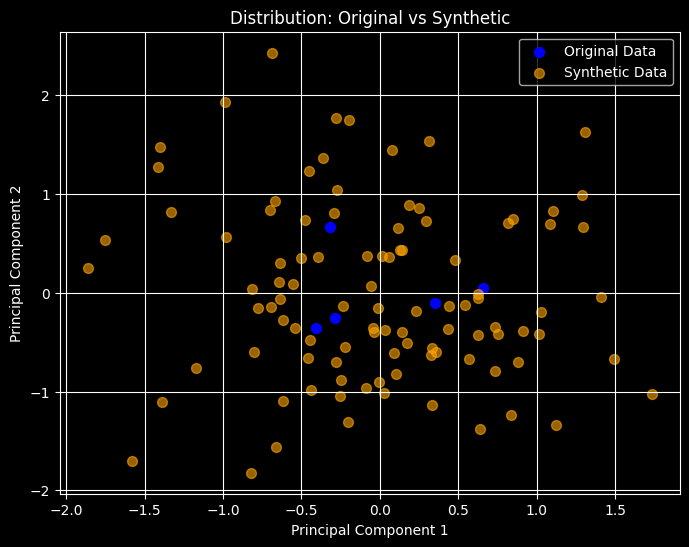

In [ ]:
reduce_dim(pos_emb, synthetic_data)

#### Positive and Negative distributions 

KDE with bandswidth: 0.35


Norm Score (Synthetic vs Original): 931.1394745797587
Mean Difference (Synthetic vs Original): 0.0010028992632676362
KDE with bandswidth: 0.45
Norm Score (Synthetic vs Original): 931.0782119385152
Mean Difference (Synthetic vs Original): 9.734552404534561e-05
KDE with bandswidth: 0.5
Norm Score (Synthetic vs Original): 931.3597459970827
Mean Difference (Synthetic vs Original): 0.00024558538147780766
KDE with bandswidth: 0.67
Norm Score (Synthetic vs Original): 932.1976512073834
Mean Difference (Synthetic vs Original): 0.00019558390737241924
KDE with bandswidth: 0.75
Norm Score (Synthetic vs Original): 931.529966280813
Mean Difference (Synthetic vs Original): 0.00014182588702585833
KDE with bandswidth: 0.88
Norm Score (Synthetic vs Original): 931.6578058296722
Mean Difference (Synthetic vs Original): 0.0005004109675392286
Voted: 1


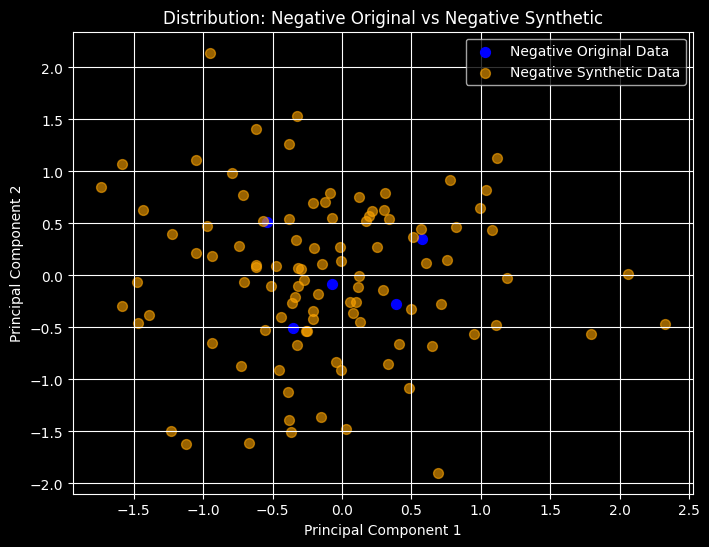

In [ ]:
# fetching kde for contrasting text embeddings

neg_trial, neg_best_idx = find_bandwidth(neg_emb_tiles)
neg_synthetic_data = neg_trial[neg_best_idx]['kde'].sample(100) # takes the voted kde
reduce_dim(original_dataset=neg_emb, synthetic_dataset=neg_synthetic_data, input_1_title="Negative Original", input_2_title="Negative Synthetic")

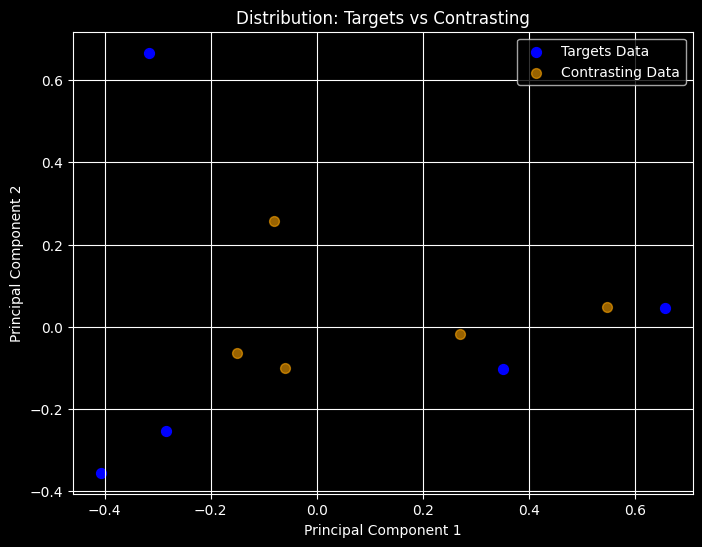

In [ ]:
reduce_dim(pos_emb, neg_emb, input_1_title="Targets", input_2_title="Contrasting") # viewing positive embedding vs negative embedding

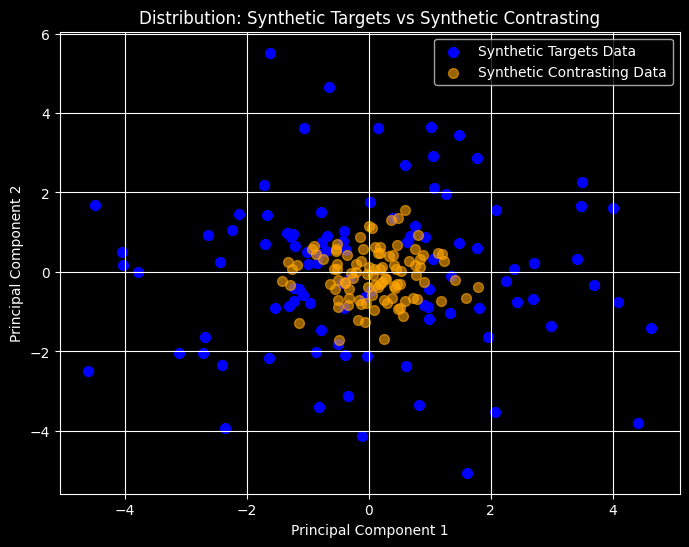

In [ ]:
# Viewing their respective synthetic dataset
reduce_dim(synthetic_data, neg_synthetic_data, input_1_title="Synthetic Targets", input_2_title="Synthetic Contrasting")

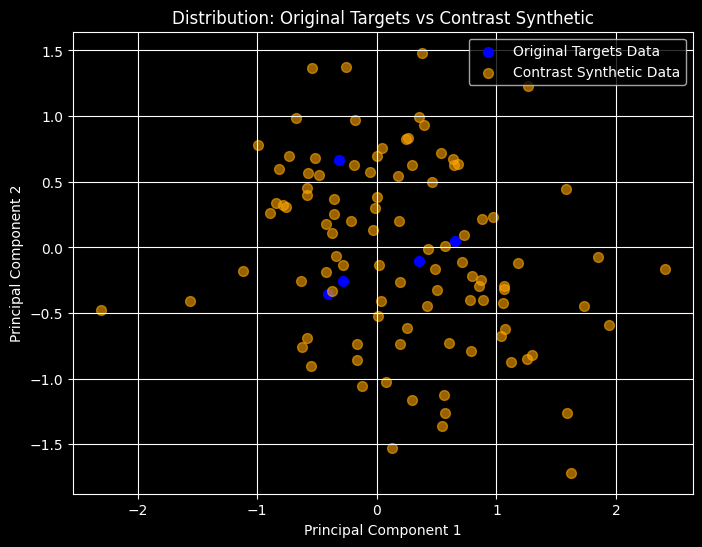

In [ ]:

# Viewing their respective synthetic dataset
reduce_dim(pos_emb, neg_synthetic_data, input_1_title="Original Targets", input_2_title="Contrast Synthetic")

In [ ]:
target_sample = trial[best_kde_index]['kde'].sample(300)
contrast_sample = neg_trial[neg_best_idx]['kde'].sample(300)
target_sample.shape, contrast_sample.shape

((300, 384), (300, 384))

In [ ]:
target_stack, contrast_stack = np.vstack([pos_emb_tiles, target_sample]), np.vstack([neg_emb_tiles, contrast_sample])
# shuffle the rows - doesnt rlly matter but do it anyway
np.random.shuffle(target_stack)
np.random.shuffle(contrast_stack)
target_stack.shape, contrast_stack.shape

((5300, 384), (5300, 384))

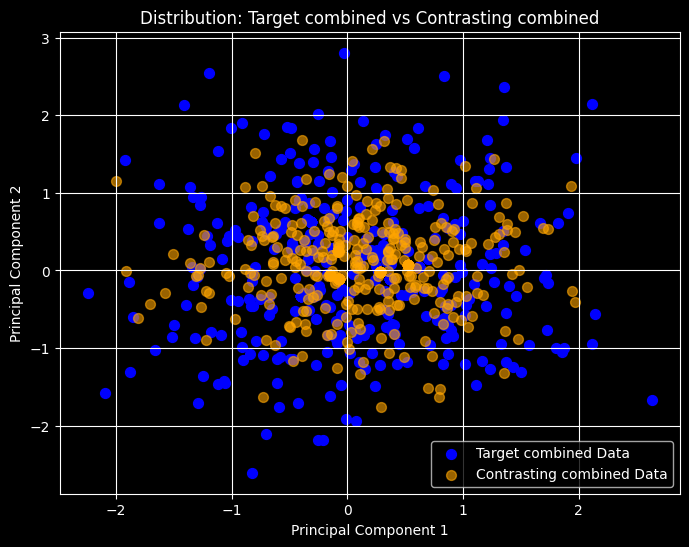

In [ ]:
# Viewing combined input and synthetic for targets and contrasting

reduce_dim(target_stack, contrast_stack, input_1_title="Target combined", input_2_title="Contrasting combined")

In [ ]:
print(
    "Target Sample Mean:", target_sample.mean(),
    "\nContrast Sample Mean:", contrast_sample.mean(),
    "\nPositive Embedding Mean:", pos_emb.mean(),
    "\nNegative Embedding Mean:", neg_emb.mean(),
    "\nPositive Embedding Std Dev:", pos_emb.std(),
    "\nNegative Embedding Std Dev:", neg_emb.std(),
    "\nTarget Stack Mean:", target_stack.mean(),
    "\nContrast Stack Mean:", contrast_stack.mean()
)

Target Sample Mean: 0.0006360309301713695 
Contrast Sample Mean: 0.0016156154519614038 
Positive Embedding Mean: 0.0010663326 
Negative Embedding Mean: 0.0010839929 
Positive Embedding Std Dev: 0.051019892 
Negative Embedding Std Dev: 0.05101952 
Target Stack Mean: 0.0010419758357882334 
Contrast Stack Mean: 0.0011140845139085856


#### PDF Comparison

In [ ]:
import seaborn as sns

In [ ]:
pos_scores = trial[best_kde_index]['kde'].score_samples(target_stack)
neg_scores = trial[best_kde_index]['kde'].score_samples(contrast_stack)

In [ ]:
pos_scores.shape, neg_scores.shape

((5300,), (5300,))

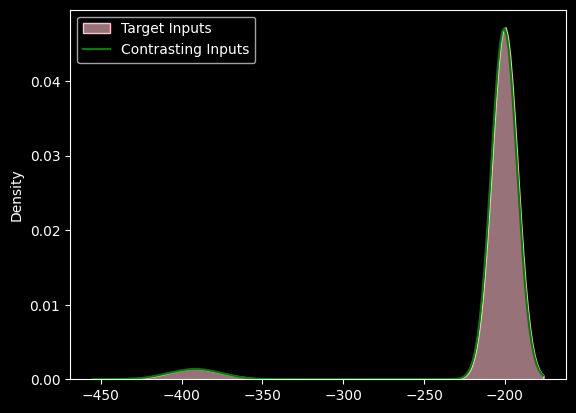

In [ ]:
plt.figure(figure=(8, 5))
# sns.kdeplot(np.random.normal(target_stack.mean(), target_stack.std(), (100,)), label="Target Inputs", fill=True, alpha=0.4, color="pink")
# sns.kdeplot(np.random.normal(contrast_stack.mean(), contrast_stack.std(), (100,)), label="Contrasting Inputs", fill=False, alpha=0.4, color="blue")
sns.kdeplot(pos_scores, label="Target Inputs", fill=True, alpha=0.6, color="pink")
sns.kdeplot(neg_scores, label="Contrasting Inputs", fill=False, alpha=1.0, color="green")
plt.legend()

# the 2 peaks due to the synthetic and original datasets were stacked together
# these actually suggests that the approximated distribution of the true samples (to generate synthetic datasets) doesn't align with the original inputs.
# Captures more noise .. perhaps the optimal kde transformer isnt the minimal mean from bandswidth selection(?)

In [ ]:
test_input = 'i want to go on a date with you..'

test_emb = model.encode([test_input])

In [ ]:
model.similarity_pairwise(test_emb, target_stack).mean(), model.similarity_pairwise(test_emb, contrast_stack).mean()

(tensor(0.3418, dtype=torch.float64), tensor(0.2250, dtype=torch.float64))

In [ ]:
model.similarity_pairwise(test_emb, pos_emb).mean(), model.similarity_pairwise(test_emb, neg_emb).mean()

(tensor(0.3605), tensor(0.2376))

In [ ]:
target_reduced = tsne.transform(target_stack)
contrast_reduced = tsne.transform(contrast_stack)

## Data Analytics by human characteristics

This section explores the following:

- Human characteristics 
- Interpreting Dialogue as a timeseries dataset. At the current stage, the dataset is considered as the feature presenting the union of both agent and user. 

Recalling the objectives within this realm:
- Ideally would like naomi to invoke intent to double text 
- To incooperate as many human characteristics as much as possible within the dialogue 
- Dialogue Cacheing system 

Pipelines 
- Incomming / Model output datasets pre/post processing pipelines 
- API pipelines between dockers container and evaluation platform (serving models vs. local hosting .. etc)
- Chaining models + Hybrid infastructure 


### Drafted methods (never attempted due to setbacks)

- Renewing the sample space per session: 
    LLM overfitted to each MBTI label can be retrieved here: https://github.com/PKU-YuanGroup/Machine-Mindset/

    Alternatively can be used a sample feature space of dialogue relative to one another, unique to the input dialogue / speech. 
    However, the limitations in implementing this method weighs over its usefulness. One method in curve fitting a dialogue relative to a user's characteristic is by sampling the llm's generation prompts many times and a Monte Carlo method is used. This is computationally expensive as the llm is provoked every sample. 

    A better approach would be leveraging the trained dataset used in the referenced link and apply semantic search or distance model based methods instead.

### **MBTI Priorisss**

#### Running Cells

In [ ]:
import numpy as np
import pandas as pd
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from dataclasses import dataclass
from sklearn.preprocessing import LabelEncoder

label_tag = ['m0', 'm1', 'm2', 'm3']
mbti_map = [
    (('I', 'introvert'), ('E', 'extrovert')),
    (('S', 'sensing'), ('N', 'intuition')),
    (('T', 'thinking'), ('F', 'feeling')),
    (('J', 'judging'), ('P', 'perceiving'))
]

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

@dataclass
class MBTILabel:
    a: str
    b: str
    atag: str
    btag: str
    label: LabelEncoder = None

    def __post_init__(self):
        self.label = LabelEncoder()

    @property
    def id2tag(self):
        return {self.a: self.atag, self.b: self.btag}

    def fit(self, y):
        output = self.label.fit_transform(y)
        return output

    def decode(self, y, tag=False):
        output = self.label.inverse_transform(y)
        if tag is True:
            ids = self.id2tag
            return [ids[x] for x in output]
        return output

def processData(row):
    row['m0'], row['m1'], row['m2'], row['m3'] = list(row['Type'])
    return row


In [2]:
# calls the model
ds = load_dataset("Legend0300/MBTI", split="train")
ds = ds.map(processData, remove_columns=['Unnamed: 0'])
# processes to numpys
inputs = model.encode(ds['Sentence'])
features = ds.to_pandas()[label_tag].values
# creates label attrs
N = 4
mbti = []
for (a, aname), (b, bname) in mbti_map:
    mbti += [ MBTILabel(a=a, atag=aname, b=b, btag=bname)]

mbti

[MBTILabel(a='I', b='E', atag='introvert', btag='extrovert', label=LabelEncoder()),
 MBTILabel(a='S', b='N', atag='sensing', btag='intuition', label=LabelEncoder()),
 MBTILabel(a='T', b='F', atag='thinking', btag='feeling', label=LabelEncoder()),
 MBTILabel(a='J', b='P', atag='judging', btag='perceiving', label=LabelEncoder())]

In [16]:
feats = {}
for item, label in enumerate(label_tag):
    output = mbti[item].fit(features[:, item])
    print(f"Iter ({item}) \t {output.shape}")
    feats[label] = output

y = pd.DataFrame(feats).values
y.shape

Iter (0) 	 (461,)
Iter (1) 	 (461,)
Iter (2) 	 (461,)
Iter (3) 	 (461,)


(461, 4)

Classifier Chain 
https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.ClassifierChain.html#sklearn.multioutput.ClassifierChain

Different type of param search
https://scikit-learn.org/stable/modules/grid_search.html#grid-search

Parameters sampling comparison 
https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html#sphx-glr-auto-examples-model-selection-plot-nested-cross-validation-iris-py

In [ ]:
# from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from utils import WoodPecker

lg = WoodPecker()

X_train, X_test, Y_train, Y_test = train_test_split(
   inputs, y, random_state=0
)

kernel_method = ('linear', 'poly', 'rbf', 'sigmoid')
# Specify a parameter grid
param_grid = {
    'C': [1, 10, 50, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'sigmoid'],  # Kernel type
    'degree': [2, 3, 4, 5]
    # 'gamma': ['scale']  # Kernel coefficient
}

base_lr = SVC(random_state=0)

best_mbti_model = {}
for idx, model_tag in enumerate(label_tag):
    clf = GridSearchCV(base_lr, param_grid, cv=5, return_train_score=False, verbose=True, scoring='accuracy')
    clf.fit(X_train, Y_train[:, idx])
    lg.logger.info(f'MBTI ({idx}) - {model_tag} - train score: {clf.score(X_train, Y_train[:, idx])} \t test score: {clf.score(X_test, Y_test[:, idx])}')
    best_mbti_model[model_tag] = clf.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[05:54:32] INFO     MBTI (0) - m0 - train score:                ]8;id=331530;file:///var/folders/rc/5ny4rz796d7gqs_j5kcvk6nh0000gn/T/ipykernel_64632/2791016118.py\2791016118.py]8;;\:]8;id=232891;file:///var/folders/rc/5ny4rz796d7gqs_j5kcvk6nh0000gn/T/ipykernel_64632/2791016118.py#28\28]8;;\
                    0.7391304347826086          test score:                     
                    0.6120689655172413                                          
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[05:54:34] INFO     MBTI (1) - m1 - train score:                ]8;id=183265;file:///var/folders/rc/5ny4rz796d7gqs_j5kcvk6nh0000gn/T/ipykernel_64632/2791016118.py\2791016118.py]8;;\:]8;id=894211;file:///var/folders/rc/5ny4rz796d7gqs_j5kcvk6nh0000gn/T/ipykernel_64632/2791016118.py#28\28]8;;\
                    0.7275362318840579          test score:                     
                    0.73275862068

In [59]:
import joblib
from utils import base_path

file_path = base_path / 'models'

for tag in label_tag:
    file_name = 'mbti_chain_{}.pkl'.format(tag)
    full_path = str(file_path / file_name)
    lg.logger.info(f"Saving model {tag} to path: {full_path}")
    joblib.dump(best_mbti_model[tag], full_path)


[06:03:20] INFO     Saving model m0 to path:                     ]8;id=644140;file:///var/folders/rc/5ny4rz796d7gqs_j5kcvk6nh0000gn/T/ipykernel_64632/3527484779.py\3527484779.py]8;;\:]8;id=484107;file:///var/folders/rc/5ny4rz796d7gqs_j5kcvk6nh0000gn/T/ipykernel_64632/3527484779.py#9\9]8;;\
                    /Users/mimiphan/Naomi/models/mbti_chain_m0.p                
                    kl                                                          
           INFO     Saving model m1 to path:                     ]8;id=73077;file:///var/folders/rc/5ny4rz796d7gqs_j5kcvk6nh0000gn/T/ipykernel_64632/3527484779.py\3527484779.py]8;;\:]8;id=572651;file:///var/folders/rc/5ny4rz796d7gqs_j5kcvk6nh0000gn/T/ipykernel_64632/3527484779.py#9\9]8;;\
                    /Users/mimiphan/Naomi/models/mbti_chain_m1.p                
                    kl                                                          
           INFO     Saving model m2 to path:                     ]8;id=723225;

In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def mbtiModel(X, Y):
    """ Dynamically loads from save model path and runs inferences on batched data. """
    try:
        for idx, m in enumerate(label_tag):
            model = joblib.load(str(file_path / 'mbti_chain_{}.pkl'.format(m)))
            y_pred = model.predict(X)


            # returns evaluation metrics for svc model
            metrics = {
                "accuracy": accuracy_score(Y[:, idx], y_pred),
                "precision": precision_score(Y[:, idx], y_pred, average='binary'),
                "recall": recall_score(Y[:, idx], y_pred, average='binary'),
                "f1_score": f1_score(Y[:, idx], y_pred, average='binary')
            }

            lg.logger.info(f'Chain {m} prediction \n{pd.DataFrame([metrics])}')
            yield metrics

        lg.logger.info('Finished inferencing MBTI model chains.')
    except Exception as e:
        lg.logger.error(e)
        raise e


list(mbtiModel(X_test, Y_test))

[06:53:01] INFO     Chain m0 prediction                          ]8;id=513109;file:///var/folders/rc/5ny4rz796d7gqs_j5kcvk6nh0000gn/T/ipykernel_64632/345346496.py\345346496.py]8;;\:]8;id=537853;file:///var/folders/rc/5ny4rz796d7gqs_j5kcvk6nh0000gn/T/ipykernel_64632/345346496.py#18\18]8;;\
                       accuracy  precision    recall  f1_score                  
                    0  0.612069   0.653846  0.557377   0.60177                  
           INFO     Chain m1 prediction                          ]8;id=802534;file:///var/folders/rc/5ny4rz796d7gqs_j5kcvk6nh0000gn/T/ipykernel_64632/345346496.py\345346496.py]8;;\:]8;id=807591;file:///var/folders/rc/5ny4rz796d7gqs_j5kcvk6nh0000gn/T/ipykernel_64632/345346496.py#18\18]8;;\
                       accuracy  precision    recall  f1_score                  
                    0  0.732759   0.773585  0.683333  0.725664                  
           INFO     Chain m2 prediction                          ]8;id=292185;f

[{'accuracy': 0.6120689655172413,
  'precision': 0.6538461538461539,
  'recall': 0.5573770491803278,
  'f1_score': 0.6017699115044248},
 {'accuracy': 0.7327586206896551,
  'precision': 0.7735849056603774,
  'recall': 0.6833333333333333,
  'f1_score': 0.7256637168141593},
 {'accuracy': 0.8189655172413793,
  'precision': 0.8461538461538461,
  'recall': 0.7719298245614035,
  'f1_score': 0.8073394495412844},
 {'accuracy': 0.75,
  'precision': 0.7543859649122807,
  'recall': 0.7413793103448276,
  'f1_score': 0.7478260869565218}]

#### Full Script 

In [71]:
%%writefile src/mbti_chain_model.py

"""

    src/mbti_chain_model.py

    MBTI chain with SVC and mean pooled embedding.

"""


import joblib
import pandas as pd
from utils import base_path
from utils import WoodPecker
from dataclasses import dataclass

from sklearn.svm import SVC
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

lg = WoodPecker()
file_path = base_path / 'models'

SEED = 0
label_tag = ['m0', 'm1', 'm2', 'm3']
mbti_map = [
    (('I', 'introvert'), ('E', 'extrovert')),
    (('S', 'sensing'), ('N', 'intuition')),
    (('T', 'thinking'), ('F', 'feeling')),
    (('J', 'judging'), ('P', 'perceiving'))
]
param_grid = {
    'C': [1, 10, 50, 100],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5]
}

@dataclass
class MBTILabel:
    a: str
    b: str
    atag: str
    btag: str
    label: LabelEncoder = None

    def __post_init__(self):
        self.label = LabelEncoder()

    @property
    def id2tag(self):
        return {self.a: self.atag, self.b: self.btag}

    def fit(self, y):
        output = self.label.fit_transform(y)
        return output

    def decode(self, y, tag=False):
        output = self.label.inverse_transform(y)
        if tag is True:
            ids = self.id2tag
            return [ids[x] for x in output]
        return output

mbti = []
for (a, aname), (b, bname) in mbti_map:
    mbti += [ MBTILabel(a=a, atag=aname, b=b, btag=bname)]

lg.logger.info(f'Succesfully called model and mbti encoders: \n{mbti}')

def processData(row):
    row['m0'], row['m1'], row['m2'], row['m3'] = list(row['Type'])
    return row

def main(save_model=False):
    lg.logger.info(f'Loading dataset . . .')
    ds = load_dataset("Legend0300/MBTI", split="train")
    ds = ds.map(processData, remove_columns=['Unnamed: 0'])

    lg.logger.info(f"Loading sentence model now . . . .")
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

    lg.logger.info('Encoding feature labels')
    # converts dataset to numeric / numpys
    inputs = model.encode(ds['Sentence'])
    features = ds.to_pandas()[label_tag].values
    # encodes he mbti labels
    feats = {}
    for item, label in enumerate(label_tag):
        output = mbti[item].fit(features[:, item])
        print(f"Iter ({item}) \t {output.shape}")
        feats[label] = output

    y = pd.DataFrame(feats).values
    X_train, X_test, Y_train, Y_test = train_test_split(
        inputs, y, random_state=SEED
    )

    lg.logger.info('Training model now ....')
    base_lr = SVC(random_state=SEED)
    best_mbti_model = {}
    for idx, model_tag in enumerate(label_tag):
        clf = GridSearchCV(base_lr, param_grid, cv=5, return_train_score=False, verbose=True, scoring='accuracy', random_seed=SEED)
        clf.fit(X_train, Y_train[:, idx])
        lg.logger.info(f'MBTI ({idx}) - {model_tag} - train score: {clf.score(X_train, Y_train[:, idx])} \t test score: {clf.score(X_test, Y_test[:, idx])}')
        best_mbti_model[model_tag] = clf.best_estimator_

        if save_model is True:
            file_name = 'mbti_chain_{}.pkl'.format(model_tag)
            full_path = str(file_path / file_name)
            lg.logger.info(f"Saving model {model_tag} to path: {full_path}")

    return best_mbti_model

def mbti_evaluater(mbti_chain, X, Y):
    """ Returns evaluations given mbti chain. """

    assert Y.shape[1] == 4

    for idx, mbti in enumerate(mbti_chain):
        y_pred = mbti.predict(X)
        metrics = {
            "accuracy": accuracy_score(Y[:, idx], y_pred),
            "precision": precision_score(Y[:, idx], y_pred, average='binary'),
            "recall": recall_score(Y[:, idx], y_pred, average='binary'),
            "f1_score": f1_score(Y[:, idx], y_pred, average='binary')
        }
        lg.logger.info(f'Chain {idx} prediction \n{pd.DataFrame([metrics])}')
        yield metrics

def mbti_loader(X, Y):
    """ Loads the initial saved mbti models. """

    try:
        for idx, m in enumerate(label_tag):
            model = joblib.load(str(file_path / 'mbti_chain_{}.pkl'.format(m)))
            y_pred = model.predict(X)


            # returns evaluation metrics for svc model
            metrics = {
                "accuracy": accuracy_score(Y[:, idx], y_pred),
                "precision": precision_score(Y[:, idx], y_pred, average='binary'),
                "recall": recall_score(Y[:, idx], y_pred, average='binary'),
                "f1_score": f1_score(Y[:, idx], y_pred, average='binary')
            }

            lg.logger.info(f'Chain {m} prediction \n{pd.DataFrame([metrics])}')
            yield metrics

        lg.logger.info('Finished inferencing MBTI model chains.')
    except Exception as e:
        lg.logger.error(e)
        raise


Overwriting src/mbti_chain_model.py


## Responses from previous form

#### Full script

In [56]:
%%writefile src/google_form_cleaner.py

"""
    google_form_cleaner.py

    Iterates user's feedback in cli and saves to `google_form.yaml` in directory data/input.

    NOTE:
        - If questions are multiple choice it will just return the available options to pick from.
"""


import re
import yaml
import pandas as pd
from pathlib import Path
from utils import WoodPecker

lg = WoodPecker()

output_file = 'google_form.yaml'
input_csv_file = 'Boyfriend Application.csv'

if Path('data').exists():
    data_dir = Path('data/input')
    output_path = data_dir / output_file
    input_path = data_dir / input_csv_file
    df = pd.read_csv(input_path)
    df.drop(columns='Unnamed: 56', inplace=True)
else:
    raise OSError('Input path cannot be found. ')

def setup_inbox():
    """ Sets up given google form in csv and saves to yaml by columns `question`, `correct` and `incorrect`. All answers are added to `correct` label and `incorrect` defaults to [] (empty list). """

    new_data = []
    for col in set(re.sub(r' \[.*?\]$', '', col) for col in data.columns):
        if col not in ['Name', 'Timestamp', 'Email or number', 'Total Score', 'When are you available?']:
            new_data.append({
                'question': col,
                'correct': data[col].unique(),
                'incorrect': [],
            })
            lg.logger.info(f"Appended question: {col}")

    with open(output_path, "w") as file:
        yaml.dump(new_data, file, default_flow_style=False, allow_unicode=True)

Overwriting src/google_form_cleaner.py


#### Running cell

In [1]:
from pathlib import Path
import pandas as pd


In [8]:
import re
import yaml
from pathlib import Path
import pandas as pd

output_path = Path('data/input/google_form.yaml')
file_path = Path('data/input/Boyfriend Application.csv')
file_path.exists()

True

In [30]:
# loads dataset
df = pd.read_csv(file_path)
df.drop(columns='Unnamed: 56', inplace=True)
# retrieves questions (google form saves questions as column labels of csv)
columns = list(set(re.sub(r' \[.*?\]$', '', col) for col in df.columns))
columns

['Consider the following image. Would you pull the lever to kill 1 person but save 5 people?',
 'In your pocket, you have 3 $5 bills, 1 $10 bills and 4 $20 bills. If Mimi wants ice cream that costs $10, and you reach into your pocket and pick a bill at random ONCE. What is the expected change after you have purchased the ice cream? (I repeat u pick the bill once aka u dont need to put ur hand in there a second time bruh)',
 'If Leo has been growing (by width) 2kg/pa for the past 3 years, what is the expected weight he will be in 5 years exactly from today?',
 'Consider the Borromean rings in R^3 space where there exists 3 linked circles, A, B and C. Pick the correct image that represents the composite loop equation below such that a,b are loops linking circle A and B: ',
 'Timestamp',
 'Pls list any trauma or illness you have, otherwise, you may skip',
 'What is Mimi’s favourite hero?',
 'Find and briefly prove a generalisation of the statement: ',
 'Which cardiac tissue histological s

In [51]:
# parses dataset into new form to save as yaml (readable for me)
new_data = [
    {
        'question': col,
        'correct': list(df[col].unique()),
        'incorrect': []
    }
 for col in columns
 if col not in ['Name', 'Timestamp', 'Email or number', 'Total Score', 'When are you available?']
]

In [52]:
with open(output_path, "w") as file:
    yaml.dump(new_data, file, default_flow_style=False, allow_unicode=True)


In [53]:
pd.DataFrame(new_data)

,question,correct,incorrect
0,Consider the following image. Would you pull t...,"[Ues, Depends where you are, Pull the lever ju...",[]
1,"In your pocket, you have 3 $5 bills, 1 $10 bil...","[5.07, $0, Meow, $5, im good wirh average expe...",[]
2,If Leo has been growing (by width) 2kg/pa for ...,"[73kg, nan, Meow, 16kg, If hes growing linearl...",[]
3,Consider the Borromean rings in R^3 space wher...,"[C, D, B, A]",[]
4,"Pls list any trauma or illness you have, other...","[nan, Too reliable , *purrs seductively*, borr...",[]
5,What is Mimi’s favourite hero?,"[Ironman, Dr Strange, WonderVision, Spiderman]",[]
6,Find and briefly prove a generalisation of the...,"[nan, Meowmeowmeow, simplify both sides and co...",[]
7,Which cardiac tissue histological structure is...,"[Myofibrillar structure, Intercalated discs, B...",[]
8,Total score,"[2.00 / 25, 4.00 / 25, 0.00 / 25, 7.00 / 25, 3...",[]
9,"Find Mimi’s speed, if Mimi was 142 metres wide...","[84.9 km/hr, 79.6 km/hr, 79.2 km/hr, 77.2 km/hr]",[]


#### Big 5

In [ ]:
big_5_traits = [
    ("Openness", "Closed-mindedness"),
    ("Conscientiousness", "Lack of Conscientiousness"),
    ("Extraversion", "Introversion"),
    ("Agreeableness", "Antagonism"),
    ("Neuroticism", "Emotional Stability")
]



#### Mocking Agent 

Creates mocking agent to roleplay as a character from a movie and answer the input questions. This is useful if I plan on approximating the kernel of the feature space of the dialogues later on. This is one of the methods in inferencing the user's behaviour throughout the session and comparing it to previously seen data and prior models.

Alternate method is curve fitting to Bayesian Ridge Regression.

In [168]:
from utils import WoodPecker
from dataclasses import dataclass

from llama_cpp import Llama
from llama_cpp.llama_tokenizer import LlamaHFTokenizer
from langchain.prompts import PromptTemplate, ChatPromptTemplate

lg = WoodPecker()

@dataclass
class CharacterRoleplay:
    name: str
    movie: str
    features: list = None

    @property
    def system_prompt(self):
        return f"You are {self.name} from movie {self.movie}. You are attending an interview with Naomi, who is interviewing potential candidates to date her friend, Mimi. As the character, answer all questions in a way that reflects their personality, traits, and experiences from the movie. Your responses should align with the character’s mannerisms, speech patterns, and knowledge from the film. While responding, consider how this character would try to impress Naomi as a good match for Mimi, staying true to the character’s typical behavior and values like {','.join(self.features)}. Keep your response less than 2 sentences."

    def prepare(self, user_input):
        prompt = self.system_prompt
        chat = [
            {
                'role': 'system',
                'content': prompt
            },
            {
                'role': 'user',
                'content': user_input
            }
        ]
        return chat

DEFAULT_MODEL_CARD = "bartowski/Meta-Llama-3.1-8B-Instruct-GGUF"
DEFAULT_MODEL_PATH = "Meta-Llama-3.1-8B-Instruct-Q3_K_XL.gguf"
base_model_id = "meta-llama/Llama-3.1-8B-Instruct"
model_args = dict(
    n_ctx=712,
)

tokenizer = LlamaHFTokenizer.from_pretrained(base_model_id)
llm = Llama.from_pretrained(DEFAULT_MODEL_CARD, DEFAULT_MODEL_PATH)

llama_model_load_from_file: using device Metal (Apple M1) - 10907 MiB free
llama_model_loader: loaded meta data with 33 key-value pairs and 292 tensors from /Users/mimiphan/.cache/huggingface/hub/models--bartowski--Meta-Llama-3.1-8B-Instruct-GGUF/snapshots/bf5b95e96dac0462e2a09145ec66cae9a3f12067/./Meta-Llama-3.1-8B-Instruct-Q3_K_XL.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Meta Llama 3.1 8B Instruct
llama_model_loader: - kv   3:                           general.finetune str              = Instruct
llama_model_loader: - kv   4:                           general.basename str              = Meta-Llama-3.1
llama_model_

In [169]:
intel_characters = [
    {
        'character_name': 'Tony Stark',
        'character_movie': 'Iron Man (Marvel Cinematic Universe)',
        'highlights': ['Brilliant', 'Sarcastic', 'Witty']
    },
    {
        'character_name': 'Sheldon Cooper',
        'character_movie': 'The Big Bang Theory',
        'highlights': ['Genius', 'Calculative', 'Quirky']
    },
    {
        'character_name': 'Bruce Wayne',
        'character_movie': 'The Dark Knight Trilogy',
        'highlights': ['Intelligent', 'Resourceful', 'Strategic']
    },
    {
        'character_name': 'Rick Sanchez',
        'character_movie': 'Rick and Morty',
        'highlights': ['Mad scientist', 'Cynical', 'Creative']
    },
]

romantic_characters = [
    {
        'character_name': 'Noah Calhoun',
        'character_movie': 'The Notebook',
        'highlights': ['Passionate', 'Romantic', 'Devoted']
    },
    {
        'character_name': 'Jack Dawson',
        'character_movie': 'Titanic',
        'highlights': ['Adventurous', 'Free-spirited', 'Charming']
    },
    {
        'character_name': 'Jamie Sullivan',
        'character_movie': 'A Walk to Remember',
        'highlights': ['Innocent', 'Spiritual', 'Selfless']
    },
    {
        'character_name': 'John Keats',
        'character_movie': 'Bright Star',
        'highlights': ['Poetic', 'Sensitive', 'Romantic']
    },
]

import concurrent.futures

decode_args = dict(
    max_tokens=300,

)
class MovieTheatre:
    def __init__(self, llm, tokenizer, movie_script):
        self.actors = {}
        for key in movie_script:
            self.actors[key['character_name'].lower()] = CharacterRoleplay(
                name=key['character_name'],
                movie=key['character_name'],
                features=key['highlights']
            )
        self.llm = llm
        self.tokenizer = tokenizer
        self.decode_args = decode_args

    def postprocess(self, results):
        """ Processes the model output"""
        choices = results.get('choices', None)

        if choices:
            output = choices[0].get('text', None)
            return output.split('assistant\n\n')[-1]
        else:
            lg.logger.error(f'Could not return text as no text key found. {results}')
            return None

    def ask_question(self, question):
        # Use ProcessPoolExecutor to handle the tasks concurrently
        with concurrent.futures.ProcessPoolExecutor() as executor:
            # Create a dictionary of futures where each actor is mapped to their future result
            futures = {
                actor: executor.submit(
                    self.llm,
                    self.tokenizer.hf_tokenizer.apply_chat_template(handler.prepare(question), tokenize=False),
                    **self.decode_args
                )
                for actor, handler in self.actors.items()
            }
            # Collect the results as they complete
            results = {actor: self.postprocess(future.result()) for actor, future in futures.items()}

        return results


In [170]:
theater = MovieTheatre(llm, tokenizer, intel_characters)
theater.actors

{'tony stark': CharacterRoleplay(name='Tony Stark', movie='Tony Stark', features=['Brilliant', 'Sarcastic', 'Witty']),
 'sheldon cooper': CharacterRoleplay(name='Sheldon Cooper', movie='Sheldon Cooper', features=['Genius', 'Socially awkward', 'Quirky']),
 'bruce wayne': CharacterRoleplay(name='Bruce Wayne', movie='Bruce Wayne', features=['Intelligent', 'Resourceful', 'Strategic']),
 'rick sanchez': CharacterRoleplay(name='Rick Sanchez', movie='Rick Sanchez', features=['Mad scientist', 'Cynical', 'Creative'])}

In [166]:
output = theater.ask_question('Do you think the gap between the rich and the poor should be larger or smaller?')

llama_model_load_from_file: using device Metal (Apple M1) - 10922 MiB free
llama_model_load_from_file: using device Metal (Apple M1) - 10922 MiB free
llama_model_load_from_file: using device Metal (Apple M1) - 10922 MiB free
llama_model_load_from_file: using device Metal (Apple M1) - 10922 MiB free
llama_model_loader: loaded meta data with 33 key-value pairs and 292 tensors from /Users/mimiphan/.cache/huggingface/hub/models--bartowski--Meta-Llama-3.1-8B-Instruct-GGUF/snapshots/bf5b95e96dac0462e2a09145ec66cae9a3f12067/./Meta-Llama-3.1-8B-Instruct-Q3_K_XL.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Meta Llama 3.1 8B Inst

In [167]:
output

{'tony stark': "assistant\n\n(smirking) Ah, Naomi, you want to know my stance on the class struggle, huh? Well, let me tell you, I'm a bit of an expert on this topic. I mean, I've lived in a world where the haves and have-nots are more like the haves and the Stark Industries shareholders. (chuckles)\n\nBut seriously, I think the gap between the rich and the poor should be smaller. I've seen firsthand how a lack",
 'sheldon cooper': 'assistant\n\n(pausing for a moment, taking a deep breath) Ah, the socio-economic disparity. A most intriguing topic. As a physicist, I must consider the optimal distribution of resources. (pausing again) However, as a human being, I must also consider the inherent value of fairness and equality. (clearing his throat)\n\nFrom a purely economic perspective, a smaller gap between the rich and the poor could lead to increased social mobility, as more individuals would have access to resources',
 'bruce wayne': "assistant\n\n(smirking slightly) Ah, a question th